In [1111]:
import importlib
import utils
import transformers
import models
import losses

In [1112]:
from models import *
from utils import *

In [1113]:
importlib.reload(utils)
importlib.reload(transformers)
importlib.reload(models)
importlib.reload(losses)

<module 'losses' from 'd:\\Documents\\machinelearning\\cgm-paper\\src\\losses.py'>

In [1114]:
print("Current working directory: ", os.getcwd())

Current working directory:  d:\Documents\machinelearning\cgm-paper\src


In [1115]:
raw_dir = "../data/raw"
tuning_dir = "../data/tuning"

In [1116]:
assert os.path.exists(raw_dir), "Raw data directory not found"
assert os.path.exists(tuning_dir), "Tuning data directory not found"

In [1117]:
dataset = load_data(raw_dir)

Found 22 files in ../data/raw
train (139415, 47)
test (32912, 47)


In [1118]:
val_dataset = load_data(tuning_dir)

Found 2 files in ../data/tuning
train (13630, 43)
test (3002, 43)


In [1119]:
for key in dataset.keys():
    val_dataset[key] = reduce_classes(val_dataset[key])
    dataset[key] = reduce_classes(dataset[key])

In [1120]:
dataset.get("train")['Time'].isnull().sum()

0

In [1121]:
train_data = get_train_dataset(dataset['train'])
test_data = get_any_dataset(dataset['test'], dataset['train'])

      CGM  month  day  hour  minute  weekday  cgm_velo  CGM(1)  CGM(2)  \
6    71.0      5   19    12       5        2  0.010000    66.0    64.5   
7    78.0      5   19    12      10        2  0.016667    71.0    68.5   
8    90.0      5   19    12      15        2  0.023333    78.0    74.5   
9    99.0      5   19    12      20        2  0.040000    90.0    84.0   
10  110.0      5   19    12      25        2  0.030000    99.0    94.5   

       CGM(3)  CGM(4)  CGM(5)     CGM(6)  
6   64.666667   65.50    66.8  68.333333  
7   66.666667   66.25    66.6  67.500000  
8   71.666667   69.50    68.6  68.500000  
9   79.666667   76.25    73.6  72.166667  
10  89.000000   84.50    80.8  77.833333  


The tuning data will be merged with the training data and be fitted into the pipeline to be used for the validation data

In [1122]:
tuning_data = get_tuning_dataset(val_dataset['train'], dataset['train'])
val_data = get_any_dataset(val_dataset['test'], tuning_data)

In [1123]:
models = Models()

In [1124]:
trainX, trainY = train_data.drop(["CGM"], axis = 1), train_data["CGM"]
trainX.shape, trainY.shape

((123697, 12), (123697,))

In [1125]:
testX, testY = test_data.drop(["CGM"], axis = 1), test_data["CGM"]
testX.shape, testY.shape

((28455, 12), (28455,))

  0%|          | 0/1 [00:00<?, ?it/s]

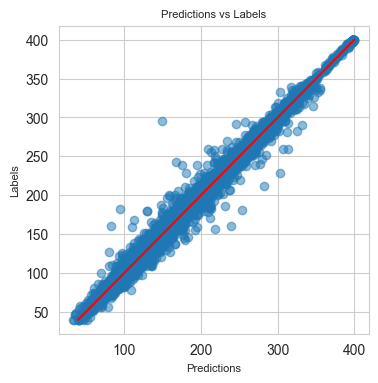

100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

Ridge MSE: 19.413260272622868, RMSE: 4.406048146879794, MSPE: 0.0862696812822765 %


In [1126]:
models.fit(trainX, trainY, testX, testY)

In [1127]:
models.forecast(testX, testY, 3)

   month  day  hour  minute  weekday  cgm_velo  CGM(1)  CGM(2)      CGM(3)  \
0      1   23    20      50        6 -0.006667   152.0   153.0  154.000000   
1      1   23    20      55        6 -0.006667   150.0   151.0  152.000000   
2      1   23    21       0        6 -0.003333   149.0   149.5  150.333333   
3      1   23    21       5        6 -0.003333   148.0   148.5  149.000000   
4      1   23    21      10        6  0.010000   151.0   149.5  149.333333   
5      1   23    21      15        6 -0.006667   149.0   150.0  149.333333   
6      1   23    21      20        6       NaN     NaN     NaN         NaN   

   CGM(4)  CGM(5)      CGM(6)                Time  
0  155.25   156.0  156.666667 2028-01-23 20:50:00  
1  153.00   154.2  155.000000 2028-01-23 20:55:00  
2  151.25   152.2  153.333333 2028-01-23 21:00:00  
3  149.75   150.6  151.500000 2028-01-23 21:05:00  
4  149.50   150.0  150.666667 2028-01-23 21:10:00  
5  149.25   149.4  149.833333 2028-01-23 21:15:00  
6     NaN  

,CGM
0,147.706841
